In [ ]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# to get deterministic output
#torch.manual_seed(123)

sys.path.append(os.path.abspath(".."))

### Hyperparameters

In [2]:
batch_size = 64
lr = 0.001
epochs = 10
image_size = 32
channels = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### DataLoader

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize to [-1, 1]
])

train_ds = datasets.CIFAR10(root="../datasets/cifar10", train=True, download=True, transform=transform)
test_ds = datasets.CIFAR10(root="../datasets/cifar10", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False, num_workers=2)

print("Train set:", len(train_ds))
print("Test set :", len(test_ds))

Train set: 50000
Test set : 10000


### Visualize the Dataset

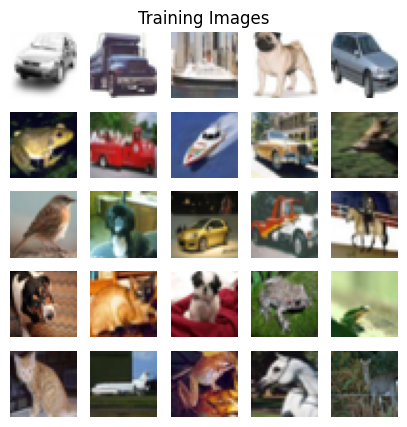

In [4]:
for images, _ in train_loader:  
    break

grid = images * 0.5 + 0.5  # denormalize
grid = grid.numpy().transpose(0, 2, 3, 1)

plt.figure(figsize=(5,5))
plt.title("Training Images")
plt.axis("off")
for k in range(25):
    plt.subplot(5,5,k+1)
    plt.imshow(grid[k], cmap="gray")
    plt.axis("off")
plt.show()

### Define the Model

In [ ]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   # input: RGB(3), output: 32
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)                # reduces image size by 2x
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(128 * 8 * 8, 256)        # after 2 poolings -> 32x32 → 8x8
        self.fc2 = nn.Linear(256, 10)                 # 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 → 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 → 8x8
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Training Loop

In [6]:
model = CIFAR10CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx/len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction="sum").item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} "
          f"({accuracy:.2f}%)\n")

# -------------------------
# Run Training
# -------------------------
for epoch in range(epochs):
    train(model, device, train_loader, optimizer, epoch+1)
    test(model, device, test_loader)


Epoch: 1 [0/50000 (0%)]	Loss: 2.301166
Epoch: 1 [6400/50000 (13%)]	Loss: 1.769266
Epoch: 1 [12800/50000 (26%)]	Loss: 1.611588
Epoch: 1 [19200/50000 (38%)]	Loss: 1.535260
Epoch: 1 [25600/50000 (51%)]	Loss: 1.344305
Epoch: 1 [32000/50000 (64%)]	Loss: 1.216202
Epoch: 1 [38400/50000 (77%)]	Loss: 1.162777
Epoch: 1 [44800/50000 (90%)]	Loss: 1.149298

Test set: Average loss: 1.1258, Accuracy: 5904/10000 (59.04%)

Epoch: 2 [0/50000 (0%)]	Loss: 1.023283
Epoch: 2 [6400/50000 (13%)]	Loss: 1.069422
Epoch: 2 [12800/50000 (26%)]	Loss: 1.045380
Epoch: 2 [19200/50000 (38%)]	Loss: 1.059206
Epoch: 2 [25600/50000 (51%)]	Loss: 0.864589
Epoch: 2 [32000/50000 (64%)]	Loss: 0.933071
Epoch: 2 [38400/50000 (77%)]	Loss: 1.178807
Epoch: 2 [44800/50000 (90%)]	Loss: 0.920256

Test set: Average loss: 0.8967, Accuracy: 6838/10000 (68.38%)

Epoch: 3 [0/50000 (0%)]	Loss: 0.844823
Epoch: 3 [6400/50000 (13%)]	Loss: 0.938265
Epoch: 3 [12800/50000 (26%)]	Loss: 0.635274
Epoch: 3 [19200/50000 (38%)]	Loss: 0.797885
Epoch: 3 [